In [11]:
import pandas as pd
import os

# Define paths
repo_path = 'dataset'
csv_path = os.path.join(repo_path, 'data', 'legend.csv')
images_path = os.path.join(repo_path, 'images')

# Load the CSV
df = pd.read_csv(csv_path)

# Inspect the first few rows to understand column names (e.g., 'image', 'emotion')
print("First 5 rows of the dataset:")
print(df.head())

# Check the shape of the dataset
print(f"\nTotal number of images: {len(df)}")

First 5 rows of the dataset:
  user.id                            image   emotion
0     628  facial-expressions_2868588k.jpg     anger
1     628  facial-expressions_2868585k.jpg  surprise
2     628  facial-expressions_2868584k.jpg   disgust
3     628  facial-expressions_2868582k.jpg      fear
4   dwdii           Aaron_Eckhart_0001.jpg   neutral

Total number of images: 13690


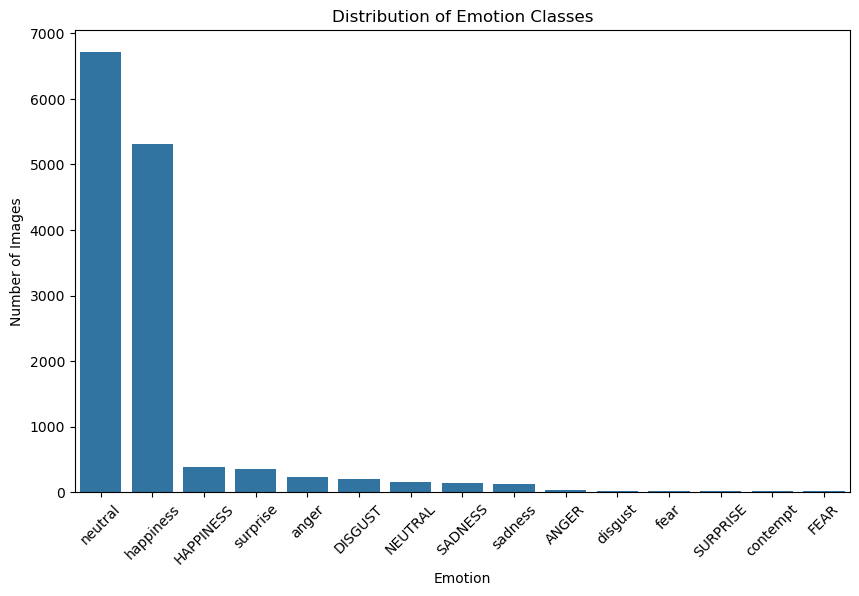

emotion
neutral      6717
happiness    5309
HAPPINESS     387
surprise      356
anger         228
DISGUST       195
NEUTRAL       151
SADNESS       144
sadness       124
ANGER          24
disgust        13
fear           13
SURPRISE       12
contempt        9
FEAR            8
Name: count, dtype: int64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(x='emotion', data=df, order=df['emotion'].value_counts().index)
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

# Print the exact counts
print(df['emotion'].value_counts())

USE Data Augementation and Class Weighting to fix class imbalance

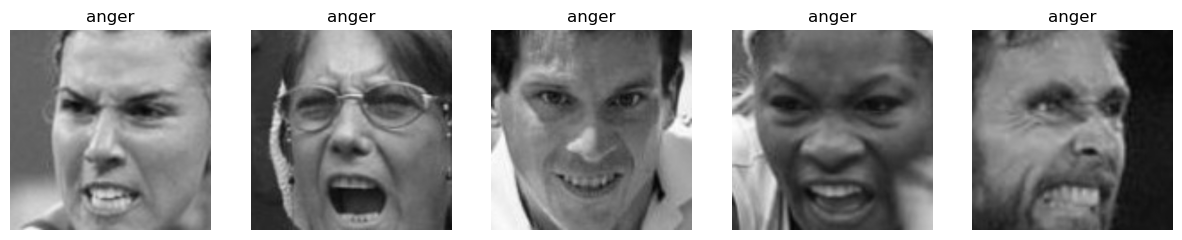

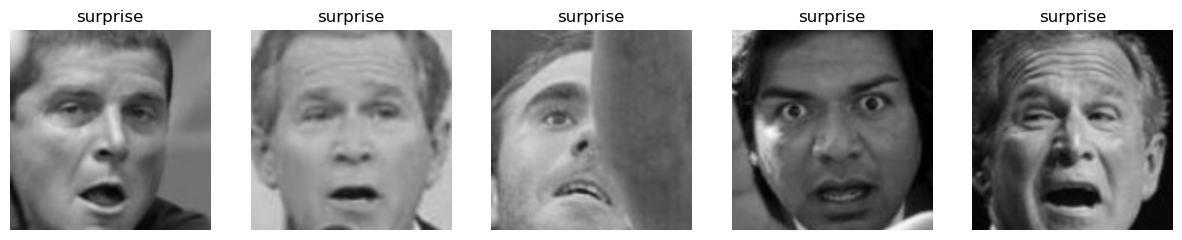

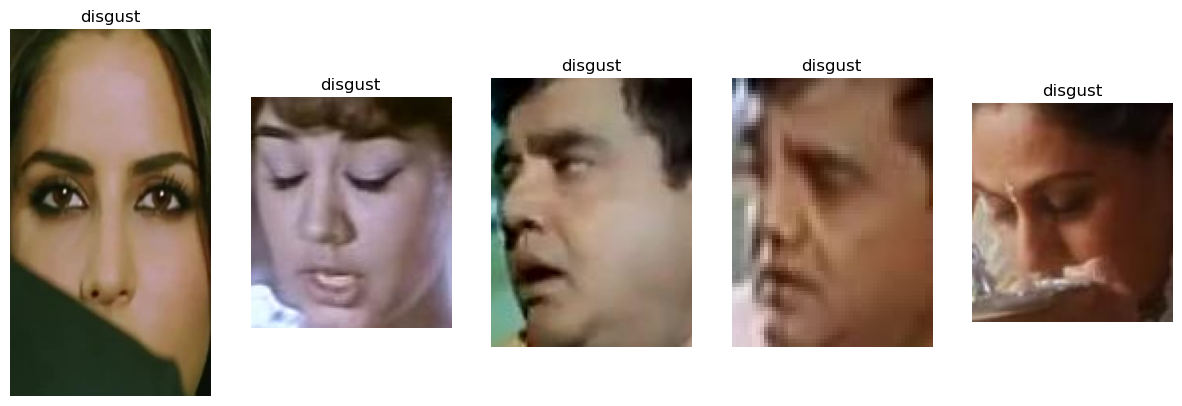

In [13]:
import cv2
import random

def show_samples(df, emotion_name, num_samples=5):
    # Filter df for the specific emotion
    emotion_df = df[df['emotion'].str.lower() == emotion_name.lower()]
    
    # Get random samples
    if len(emotion_df) < num_samples:
        samples = emotion_df['image'].values
    else:
        samples = random.sample(list(emotion_df['image'].values), num_samples)
    
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(samples):
        img_path = os.path.join(images_path, img_name)
        
        # Read image (opencv reads in BGR, convert to RGB for plotting)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, num_samples, i+1)
            plt.imshow(img)
            plt.title(emotion_name)
            plt.axis('off')
        else:
            print(f"Could not load {img_name}")
    plt.show()

# Show examples for a few common emotions
unique_emotions = df['emotion'].unique()
for emotion in unique_emotions[:3]: # Show first 3 categories
    show_samples(df, emotion)

In [14]:
# Check the shape of the first loaded image
first_image_name = df.iloc[0]['image']
img = cv2.imread(os.path.join(images_path, first_image_name))

if img is not None:
    print(f"Original Image Shape: {img.shape}") 
    # Output will be (Height, Width, Channels)
else:
    print("Error loading image.")

Original Image Shape: (536, 347, 3)


In [15]:
# Convert all emotion labels to lowercase to merge categories like 'happiness' and 'HAPPINESS'
df['emotion'] = df['emotion'].str.lower()

# Verify the new distribution
print("New Class Distribution:")
print(df['emotion'].value_counts())

New Class Distribution:
emotion
neutral      6868
happiness    5696
surprise      368
sadness       268
anger         252
disgust       208
fear           21
contempt        9
Name: count, dtype: int64


In [16]:
import cv2
import numpy as np

def is_valid_image(img_name, base_path):
    img_path = os.path.join(base_path, img_name)
    if not os.path.exists(img_path):
        return False
    try:
        # Try loading the image
        img = cv2.imread(img_path)
        return img is not None
    except:
        return False

print(f"Original Row Count: {len(df)}")
df['valid'] = df['image'].apply(lambda x: is_valid_image(x, images_path))
df_clean = df[df['valid']].copy()

print(f"Cleaned Row Count: {len(df_clean)}")
print(f"Removed {len(df) - len(df_clean)} corrupted/missing images.")

Original Row Count: 13690
Cleaned Row Count: 13690
Removed 0 corrupted/missing images.


In [8]:
from sklearn.model_selection import train_test_split

# Split into Training (80%) and Test (20%)
# stratify=df_clean['emotion'] ensures every class is represented in both sets
train_df, test_df = train_test_split(
    df_clean, 
    test_size=0.2, 
    stratify=df_clean['emotion'], 
    random_state=42
)

# Further split Train into Train (85%) and Validation (15%)
train_df, val_df = train_test_split(
    train_df, 
    test_size=0.15, 
    stratify=train_df['emotion'], 
    random_state=42
)

print(f"Train Size: {len(train_df)}")
print(f"Validation Size: {len(val_df)}")
print(f"Test Size: {len(test_df)}")

Train Size: 9309
Validation Size: 1643
Test Size: 2738


In [9]:
from sklearn.utils.class_weight import compute_class_weight

classes = sorted(train_df['emotion'].unique())

weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.array(classes), 
    y=train_df['emotion']
)

class_weight_dict = dict(zip(classes, weights))

print("Class Weights (Higher number = Model tries harder to learn this class):")
for emotion, weight in class_weight_dict.items():
    print(f"{emotion}: {weight:.2f}")

Class Weights (Higher number = Model tries harder to learn this class):
anger: 6.77
contempt: 193.94
disgust: 8.25
fear: 83.12
happiness: 0.30
neutral: 0.25
sadness: 6.36
surprise: 4.65
